In [1]:
# Importar librerías
from deepface import DeepFace
import numpy as np
import tensorflow as tf
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
import pickle

In [2]:
# Cargar Labels del CSV
def load_labels(csv_path):
    df = pd.read_csv(csv_path)
    labels_dict = {}
    for _, row in df.iterrows():
        # Convertir ClipID a str antes de usar replace y luego a int
        clip_id = str(row['ClipID']).replace('.avi', '').replace('.mp4', '')
        labels_dict[clip_id] = [
            int(row['Boredom']),
            int(row['Engagement']),
            int(row['Confusion']),
            int(row['Frustration'])
        ]
    return labels_dict

In [3]:
# Extraer embeddings FaceNet
def extract_facenet_embedding(img_path):
    try:
        embedding = DeepFace.represent(img_path=img_path, model_name='Facenet', enforce_detection=False)
        return np.array(embedding[0]['embedding'])
    except Exception as e:
        print(f"Error en {img_path}: {e}")
        return None

In [ ]:
def process_dataset(frames_root_folder, labels_csv, max_videos=1250):
    labels = load_labels(labels_csv)
    X = []
    y = []

    # Obtener todas las carpetas de video
    frames_root_folder = Path(frames_root_folder)
    video_folders = list(frames_root_folder.glob("*/*"))
    print(f"Total de carpetas de video encontradas: {len(video_folders)}")

    # Limitar a los primeros `max_videos`
    video_folders = video_folders[:max_videos]
    print(f"Procesando {len(video_folders)} carpetas de video...")

    # Procesar cada carpeta de video
    for video_folder in tqdm(video_folders, desc="Procesando videos"):
        clip_id = video_folder.name

        # Verificar si el clip_id está en labels
        if clip_id not in labels:
            with open("missing_clip_ids.txt", "a") as f:
                f.write(clip_id + "\n")
            print(f"ClipID {clip_id} no encontrado en labels.")
            continue

        emotion_levels = labels[clip_id]  # lista de 4 números

        # Crear un vector one-hot de 16 posiciones
        label_vector = np.zeros(16)
        for i, level in enumerate(emotion_levels):  # i = 0 (boredom), 1 (engagement), 2 (confusion), 3 (frustration)
            index = i * 4 + level  # cada emoción tiene 4 niveles
            label_vector[index] = 1

        video_embeddings = []
        
        # Procesar los frames dentro de esta carpeta
        for frame_path in video_folder.glob("*.jpg"):
            embedding = extract_facenet_embedding(str(frame_path))
            if embedding is not None:
                video_embeddings.append(embedding)
        
        video_embedding = np.mean(video_embeddings, axis=0)
        video_embedding = np.array(video_embedding)
        
        X.append(video_embedding)
        y.append(label_vector)

    X = np.array(X)
    y = np.array(y)

    print(f"Dataset procesado: {X.shape[0]} ejemplos.")
    return X, y

In [5]:
frames_root = "output_frames/Train"
labels_csv = "TrainLabels.csv"

# Procesar dataset
X, y = process_dataset(frames_root, labels_csv)

Total de carpetas de video encontradas: 5481
Procesando 200 carpetas de video...


Procesando videos:  98%|█████████▊| 196/200 [04:55<00:06,  1.51s/it]


KeyboardInterrupt: 

In [ ]:
#np.save('Facenet Embeddings/Train/X_train.npy', X)
#np.save('Facenet Embeddings/Train/y_train.npy', y)

In [ ]:
frames_root_val = "output_frames/Validation"
labels_csv = "AllLabels.csv"

# Procesar dataset
X_val, y_val = process_dataset(frames_root_val, labels_csv)

Total de carpetas de video encontradas: 1720
Procesando 200 carpetas de video...


Procesando videos: 100%|██████████| 200/200 [03:56<00:00,  1.18s/it]

Dataset procesado: 200 ejemplos.


In [ ]:
#np.save('Facenet Embeddings/Val/X_val.npy', X_val)
#np.save('Facenet Embeddings/Val/y_val.npy', y_val)

In [ ]:
frames_root_test = "output_frames/Test"
labels_csv = "AllLabels.csv"

# Procesar dataset
X_test, y_test = process_dataset(frames_root_test, labels_csv)

Total de carpetas de video encontradas: 1866
Procesando 200 carpetas de video...


Procesando videos: 100%|██████████| 200/200 [03:48<00:00,  1.14s/it]

Dataset procesado: 200 ejemplos.


In [ ]:
#np.save('Facenet Embeddings/Test/X_test.npy', X_test)
#np.save('Facenet Embeddings/Test/y_test.npy', y_test)

In [ ]:
# Entrada
input_layer = Input(shape=(X.shape[1],))

# Base
x = Dense(512, activation='relu')(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)

x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)

# 4 salidas
out_boredom = Dense(4, activation='softmax', name='boredom')(x)
out_engagement = Dense(4, activation='softmax', name='engagement')(x)
out_confusion = Dense(4, activation='softmax', name='confusion')(x)
out_frustration = Dense(4, activation='softmax', name='frustration')(x)

# Modelo final
model = Model(inputs=input_layer, outputs=[out_boredom, out_engagement, out_confusion, out_frustration])

# Compilar
model.compile(
    optimizer='adam',
    # Multiclass clasification loss for each output one-hot
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 128)]                0         []                            
                                                                                                  
 dense_43 (Dense)            (None, 512)                  66048     ['input_10[0][0]']            
                                                                                                  
 batch_normalization (Batch  (None, 512)                  2048      ['dense_43[0][0]']            
 Normalization)                                                                                   
                                                                                                  
 dropout_20 (Dropout)        (None, 512)                  0         ['batch_normalization[0]

In [ ]:
y_boredom_train = y[:, 0:4]
y_engagement_train = y[:, 4:8]
y_confusion_train = y[:, 8:12]
y_frustration_train = y[:, 12:16]

y_boredom_val = y_val[:, 0:4]
y_engagement_val = y_val[:, 4:8]
y_confusion_val = y_val[:, 8:12]
y_frustration_val = y_val[:, 12:16]

y_boredom_test = y_test[:, 0:4]
y_engagement_test = y_test[:, 4:8]
y_confusion_test = y_test[:, 8:12]
y_frustration_test = y_test[:, 12:16]

In [ ]:
history = model.fit(
    X, [y_boredom_train, y_engagement_train, y_confusion_train, y_frustration_train],
    validation_data=(X_val, [y_boredom_val, y_engagement_val, y_confusion_val, y_frustration_val]),
    epochs=100,
    batch_size=32,
    #callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
7/7 [==============================] - 4s 95ms/step - loss: 7.1623 - boredom_loss: 1.7902 - engagement_loss: 1.6524 - confusion_loss: 1.8590 - frustration_loss: 1.8607 - boredom_accuracy: 0.2900 - engagement_accuracy: 0.3450 - confusion_accuracy: 0.2300 - frustration_accuracy: 0.2600 - val_loss: 5.3298 - val_boredom_loss: 1.3894 - val_engagement_loss: 1.3214 - val_confusion_loss: 1.3345 - val_frustration_loss: 1.2844 - val_boredom_accuracy: 0.2000 - val_engagement_accuracy: 0.5800 - val_confusion_accuracy: 0.3100 - val_frustration_accuracy: 0.5250
Epoch 2/100
7/7 [==============================] - 0s 8ms/step - loss: 6.5361 - boredom_loss: 1.5657 - engagement_loss: 1.5397 - confusion_loss: 1.6597 - frustration_loss: 1.7710 - boredom_accuracy: 0.4150 - engagement_accuracy: 0.4450 - confusion_accuracy: 0.3450 - frustration_accuracy: 0.2800 - val_loss: 5.3603 - val_boredom_loss: 1.3726 - val_engagement_loss: 1.3810 - val_confusion_loss: 1.3184 - val_frustration_loss: 1.2883 - 

In [ ]:
#with open('history.pkl', 'wb') as f:
#    pickle.dump(history.history, f)
#
#model.save("model-mean.h5")
#model = models.load_model("model-all.h5")

In [ ]:
#with open('history.pkl', 'rb') as f:
#    history = pickle.load(f)

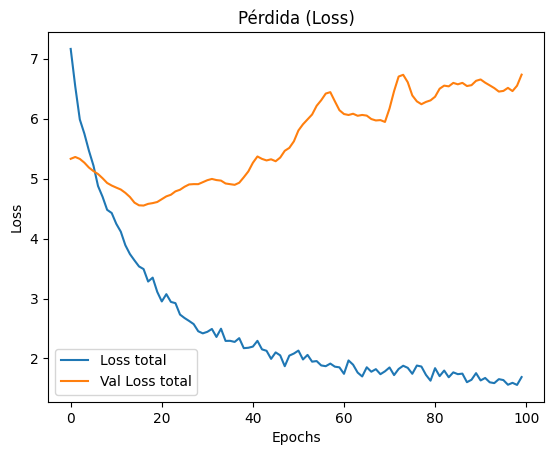

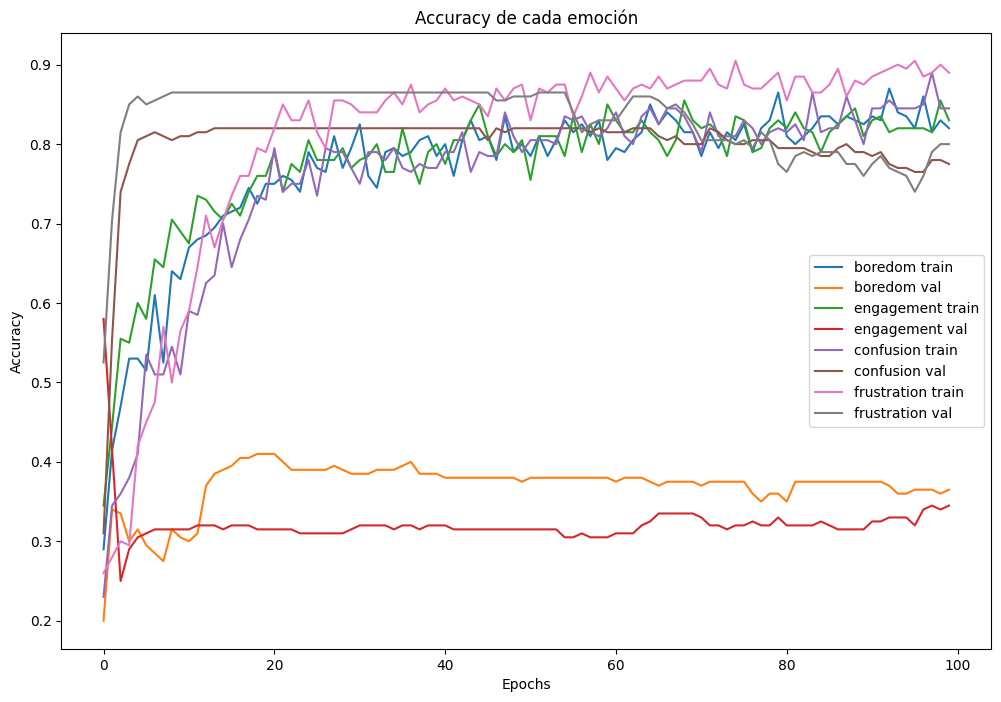

In [ ]:
# Loss
plt.plot(history.history['loss'], label='Loss total')
plt.plot(history.history['val_loss'], label='Val Loss total')
plt.title('Pérdida (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy de cada salida
plt.figure(figsize=(12, 8))
for output in ['boredom', 'engagement', 'confusion', 'frustration']:
    plt.plot(history.history[f'{output}_accuracy'], label=f'{output} train')
    plt.plot(history.history[f'val_{output}_accuracy'], label=f'{output} val')

plt.title('Accuracy de cada emoción')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

7/7 [==============================] - 0s 1ms/step


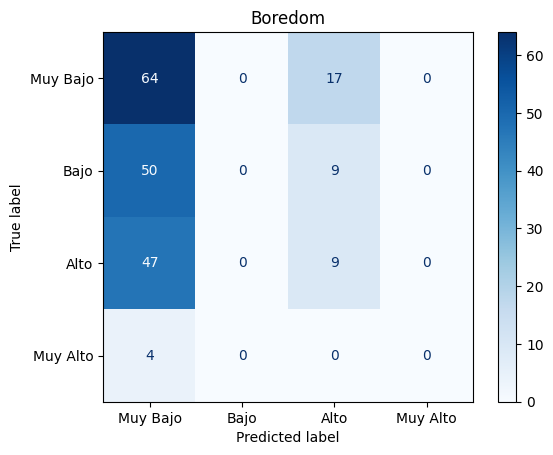

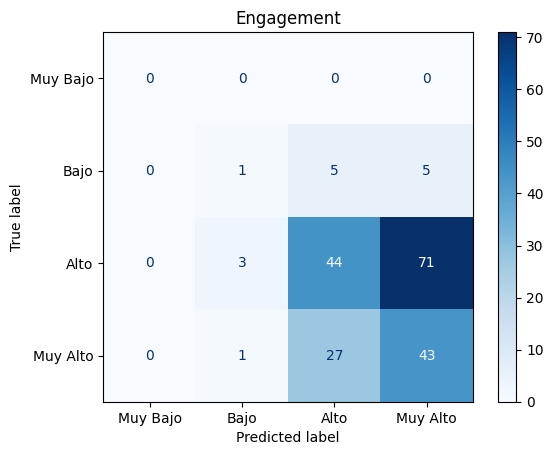

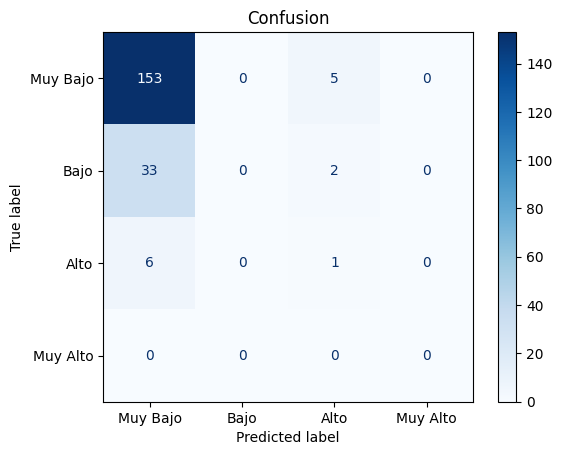

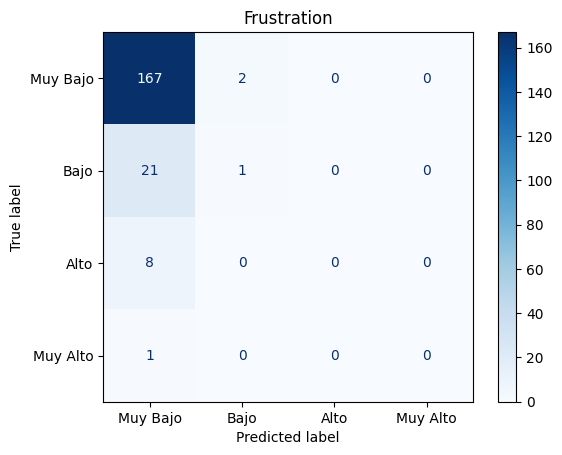

In [ ]:
# Predecir
y_pred = model.predict(X_test)

# y_pred es una lista: [boredom, engagement, confusion, frustration]
pred_boredom = np.argmax(y_pred[0], axis=1)
pred_engagement = np.argmax(y_pred[1], axis=1)
pred_confusion = np.argmax(y_pred[2], axis=1)
pred_frustration = np.argmax(y_pred[3], axis=1)

true_boredom = np.argmax(y_boredom_test, axis=1)
true_engagement = np.argmax(y_engagement_test, axis=1)
true_confusion = np.argmax(y_confusion_test, axis=1)
true_frustration = np.argmax(y_frustration_test, axis=1)

# Función para graficar
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Muy Bajo", "Bajo", "Alto", "Muy Alto"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Dibujar las 4 matrices
plot_confusion_matrix(true_boredom, pred_boredom, "Boredom")
plot_confusion_matrix(true_engagement, pred_engagement, "Engagement")
plot_confusion_matrix(true_confusion, pred_confusion, "Confusion")
plot_confusion_matrix(true_frustration, pred_frustration, "Frustration")

In [240]:
from sklearn.metrics import classification_report

def evaluar_emocion(y_true, y_pred, nombre_emocion):
    print(f"Evaluación para {nombre_emocion}:")
    print(classification_report(
        y_true, 
        y_pred, 
        labels=[0,1,2,3],
        target_names=["Muy Bajo", "Bajo", "Alto", "Muy Alto"]
    ))
    print("-" * 50)

# Para cada emoción:
evaluar_emocion(true_boredom, pred_boredom, "Boredom")
evaluar_emocion(true_engagement, pred_engagement, "Engagement")
evaluar_emocion(true_confusion, pred_confusion, "Confusion")
evaluar_emocion(true_frustration, pred_frustration, "Frustration")

Evaluación para Boredom:
              precision    recall  f1-score   support

    Muy Bajo       0.39      0.79      0.52        81
        Bajo       0.00      0.00      0.00        59
        Alto       0.26      0.16      0.20        56
    Muy Alto       0.00      0.00      0.00         4

    accuracy                           0.36       200
   macro avg       0.16      0.24      0.18       200
weighted avg       0.23      0.36      0.27       200

--------------------------------------------------
Evaluación para Engagement:
              precision    recall  f1-score   support

    Muy Bajo       0.00      0.00      0.00         0
        Bajo       0.20      0.09      0.12        11
        Alto       0.58      0.37      0.45       118
    Muy Alto       0.36      0.61      0.45        71

    accuracy                           0.44       200
   macro avg       0.29      0.27      0.26       200
weighted avg       0.48      0.44      0.44       200

--------------------------